OmicIDX is a project to democratize access to omics *metadata*. As the sizes of omics
repositories have grown into the millions of available samples, thinking of the 
metadata themselves as **Big Data** seems reasonable. Additionally, by making the 
metadata more fit-for-use for text mining, natural language processing, ingestion into
machine learning or search engines, OmicIDX aims to facilitate augmentation and analysis
of these metadata. 

In practice, the OmicIDX mines data from the NCBI [Sequence Read Archive (SRA)] (updated monthly) and
NCBI [Biosample] databases (updated daily). 

[Biosample]: https://www.ncbi.nlm.nih.gov/biosample/
[Sequence Read Archive (SRA)]: https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?

## What is BigQuery?

[BigQuery] is an enterprise data warehouse and database. It is managed by Google, meaning
there are no servers to set up, storage to manage, or configuration. Access to data stored in 
BigQuery can be public, limited to individuals, or to just the owner. 

In the case of OmicIDX, the data in BigQuery are publicly accessible. Querying the data
still requires an account and billing to be activated, but Google offers free credits to 
new users that will allow *many* queries against the OmicIDX data.

# Getting started

Before using BigQuery in python, one needs to create an account with Google and activate the
BigQuery engine. 

**See [here](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-web-ui) for the quickstart
tutorial. (5 minutes)**

After completing the quickstart, navigate to:

https://console.cloud.google.com/bigquery?project=isb-cgc-01-0006&folder&organizationId&p=isb-cgc-01-0006&d=omicidx&page=dataset

On the left panel, you should now see the `isb-cgc-01-0006` project. Expanding that item, the `omicidx` 
dataset is available. 

At this point, explore the OmicIDX data via the Google Console. BigQuery uses standard SQL 
for queries. 

# Python access to BigQuery

- Install [google-cloud-bigquery](https://cloud.google.com/bigquery/docs/reference/libraries) and follow instructions
go get started.

Note that while I am using python here, BigQuery client libraries are available for 
many languages. A command-line client (bq) is also available for shell scripting, etc.

# Examples

From here on out, the code can speak for itself. For more details on using BigQuery from python, check out the [documentation](https://googleapis.github.io/google-cloud-python/latest/bigquery/index.html)

In [1]:
from google.cloud import bigquery

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = bigquery.Client()

## Studies published by year

In [4]:
sql_query = """
SELECT 
    DATE(
    EXTRACT(YEAR FROM publish_date),
    EXTRACT(MONTH FROM publish_date),
    1) as month,
    count(*) as studies
FROM `isb-cgc-01-0006.omicidx.sra_study` 
where publish_date <= CURRENT_TIMESTAMP()
GROUP BY month
ORDER BY month desc;
"""

Here, use a convenience method to convert results to a pandas dataframe. 

In [5]:
res = client.query(sql_query).to_dataframe()

In [6]:
res.head()

,month,studies
0,2019-06-01,219
1,2019-05-01,4762
2,2019-04-01,4230
3,2019-03-01,2796
4,2019-02-01,4132


The [seaborn](https://seaborn.pydata.org/) library is a high-level plotting library based on matplotlib. 

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
import seaborn as sns
sns.scatterplot(x = "month", y = "studies", data = res)

## Experiments by type

The `sra_experiment` table contains most of the details about the experimental
strategies. In particular, the `library_strategy` column 

In [8]:
sql_query = """
SELECT library_strategy, count(*) as count
FROM `isb-cgc-01-0006.omicidx.sra_experiment`
GROUP BY library_strategy 
ORDER BY count desc"""

In [9]:
res = client.query(sql_query).to_dataframe()

In [10]:
res.head(15)

,library_strategy,count
0,WGS,1839830
1,AMPLICON,1499138
2,RNA-Seq,1397258
3,OTHER,591845
4,WXS,316378
5,CLONE,134435
6,ChIP-Seq,127278
7,RAD-Seq,68102
8,POOLCLONE,57751
9,Targeted-Capture,55953


## Number of "cancer" studies

BigQuery is a capable system even for full text searching. In this case,
the `abstract`, `title`, and `description` fields for a study contain the 
largest amount of free text. Searching each separately is a possibility, 
but BigQuery has a `CONCAT` operator that can build up a single long string
for search. Converting that string to all lower-case (using `LOWER`) facilitates
case-insensitive search for `cancer`. Note that in SQL, the wildcard character
is `%`. 

In [11]:
sql_query = """
SELECT count(*) as count
FROM `isb-cgc-01-0006.omicidx.sra_study`
WHERE LOWER(CONCAT(abstract, " ", title, " ", description)) like '%cancer%'
"""

In [12]:
res = client.query(sql_query).to_dataframe()

In [13]:
print("There are {0} studies in which `cancer`  appears in the title, abstract, or description".format( res['count'][0]))

There are 734 studies in which `cancer`  appears in the title, abstract, or description


## Distribution of number of attributes per sample

The `sra_sample` table contains most of the metadata that are associated with
the "phenotype" or "characteristics" of the sample. The sample attributes are 
included in a "nested column" in BigQuery. The array length
of that the `attributes` column then gives the number of distinct attributes 
for each sample. While pulling those results, one-per-sample, back into python
is one way to proceed, writing a SQL query that creates the histogram for us
will be more efficient.

In [14]:
sql_query = """
with t as
  (SELECT array_length(attributes) as attribute_count
  FROM `isb-cgc-01-0006.omicidx.sra_sample`) 
SELECT t.attribute_count, count(*) as nbr_of_samples
  FROM t
  GROUP BY attribute_count
  ORDER BY attribute_count asc
"""

In [15]:
res = client.query(sql_query).to_dataframe()

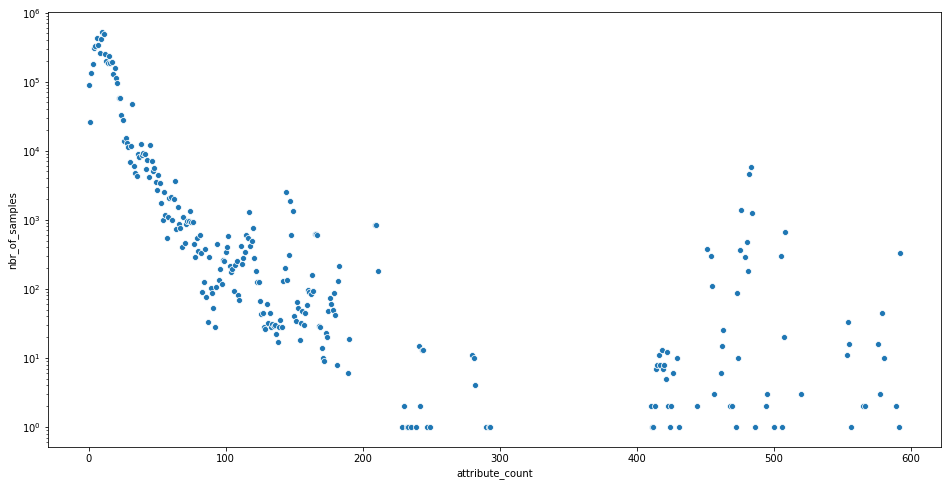

In [16]:
plt.figure(figsize=(16, 8))
g = sns.scatterplot(x="attribute_count", y="nbr_of_samples", data=res)
g.set_yscale('log')
plt.show()

# Conclusion

This little post is just to whet the appetite. BigQuery is a new technology
for many informatics folks, but it is quite powerful, extensible, and is
nearly free for datasets of even modest size. With libraries for R, python, 
java, as well as a simple command-line client, access to OmicIDX in BigQuery
is well-supported.

Other approaches to accessing OmicIDX data are forthcoming. 